In [11]:
from scipy.stats import multivariate_normal
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

In [12]:
data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')

In [13]:
del data['Index']
data['Age'] = (data['Age']-data['Age'].mean())/data['Age'].std()
data['Income'] = (data['Income']-data['Income'].mean())/data['Income'].std()
data = data.to_numpy()
print(data)

[[ 0.00000000e+00  0.00000000e+00  2.65295099e+00  2.00000000e+00
   9.74992284e-02  1.00000000e+00  2.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00 -1.18683527e+00  1.00000000e+00
   7.82458689e-01  1.00000000e+00  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.11703649e+00  1.00000000e+00
  -8.32993913e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.75722152e-01  1.00000000e+00
   1.32805410e+00  1.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.45835082e+00  1.00000000e+00
   7.36747492e-01  1.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -7.75636823e-02  1.00000000e+00
   6.26982889e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.45835082e+00  1.00000000e+00
   9.32607639e-01  1.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -7.75636823e-02  1.00000000e+00
   1.90681769e+00  2.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  2.14097949e+00  2.00000000e+0

In [14]:
class GMM:
    def __init__(self, clusters, max_iterations=1000,):
        self.clusters = clusters
        self.max_iterations = max_iterations

    def set_clusters(self, clusters):
        self.clusters = clusters

    def initialize(self, data):
        np.random.seed(42)
        self.means = np.random.rand(self.clusters, data.shape[1])
        
        self.covariances = np.array(
            [np.identity(data.shape[1]) for i in range(self.clusters)])
        self.weights = np.ones(self.clusters) / self.clusters

    def fit(self, data):
        self.initialize(data)
        prev_log_likelihood = 0
        for i in range(self.max_iterations):
            resp = self.E_step(data)
            self.M_step(data, resp)
            curr_log_likelihood = self.calculate_log_likelihood(data)
            self.log_likelihood = curr_log_likelihood
            if np.abs(curr_log_likelihood - prev_log_likelihood) < 1e-3:
                break
            prev_log_likelihood = curr_log_likelihood

    def E_step(self, data):
        responsibilities = np.zeros((data.shape[0], self.clusters))
        for i in range(data.shape[0]):
            for j in range(self.clusters):
                responsibilities[i][j] = self.weights[j] * multivariate_normal.pdf(
                    data[i], mean=self.means[j], cov=self.covariances[j])
            responsibilities[i] /= np.sum(responsibilities[i])
        return responsibilities

    def M_step(self, data, responsibilities):
        for k in range(self.clusters):
            Nk = 0
            for i in range(data.shape[0]):
                Nk += responsibilities[i][k]
            self.weights[k] = Nk/data.shape[0]

            sum = np.zeros(data.shape[1])
            for i in range(data.shape[0]):
                sum += data[i]*responsibilities[i][k]
            self.means[k] = sum/Nk

            diff = data - self.means[k]
            self.covariances[k] = np.dot(
                (responsibilities[:, k][:, np.newaxis] * diff).T, diff) / Nk
            self.covariances[k] += np.identity(data.shape[1])*1e-6

    def calculate_log_likelihood(self, data):
        log_likelihood = 0
        for i in range(data.shape[0]):
            likelihood = 0
            for k in range(self.clusters):
                likelihood += multivariate_normal.pdf(
                    data[i], self.means[k], self.covariances[k])*self.weights[k]
            log_likelihood += np.log(likelihood)
        return log_likelihood

    def get_parameters(self):
        return self.means, self.covariances, self.weights

    def get_membership_values(self, data):
        responsibilities = self.E_step(data)
        return responsibilities

    def predict(self, data):
        responsibilities = self.E_step(data)
        cluster_labels = np.argmax(responsibilities, axis=1)
        return cluster_labels

    def BIC(self, data):
        return -2*self.log_likelihood + self.clusters*np.log(data.shape[0])

    def AIC(self, data):
        return 2*(self.clusters-self.log_likelihood)

In [15]:
from sklearn.metrics import silhouette_score

gmm = GMM(4)
for k in range(4,7):
    gmm.set_clusters(k)
    gmm.fit(data)
    print(k)
    print('Log-Likelihood :',gmm.log_likelihood)
    gmm_labels = gmm.predict(data)
    silhouette_gmm = silhouette_score(data, gmm_labels)
    print('Silhouette score :',silhouette_gmm)
    print()


4
Log-Likelihood : 2150.2102399909586
Silhouette score : -0.10959448651168947

5
Log-Likelihood : 9802.741716691075
Silhouette score : 0.02299391886303341

6
Log-Likelihood : 9741.6351244494
Silhouette score : -0.07878709723530851



The silhouette score is used to measure the quality of clusters created by a clustering algorithm, it provides a way to assess how similar each data point in one cluster is to the data points in the same cluster compared to the nearest neighboring cluster.

In [16]:
from sklearn.datasets import load_wine

wine_dataset = load_wine()
wine_dataset['data'] = (wine_dataset['data'] -wine_dataset['data'].mean(axis=0))/wine_dataset['data'].std(axis=0)
wine_data = wine_dataset['data']

In [17]:
gmm=GMM(3)
aic = []
bic = []
for i in range(2, 11):
    gmm.set_clusters(i)
    gmm.fit(wine_data)
    print(i,gmm.log_likelihood)
    print('aic:',gmm.AIC(wine_data))
    print('bic:',gmm.BIC(wine_data))
    print()
    aic.append(gmm.AIC(wine_data))
    bic.append(gmm.BIC(wine_data))

2 -2287.951690861281
aic: 4579.903381722562
bic: 4586.266948823146

3 -2148.9610950296305
aic: 4303.922190059261
bic: 4313.467540710138

4 -2006.1717958493052
aic: 4020.3435916986105
bic: 4033.0707258997786

5 -1880.6922407556146
aic: 3771.3844815112293
bic: 3787.29339926269

6 -1673.6788159366354
aic: 3359.3576318732707
bic: 3378.4483331750234

7 -1593.083407263706
aic: 3200.166814527412
bic: 3222.4392993794568

8 -1399.2048907085075
aic: 2814.409781417015
bic: 2839.8640498193517

9 -1267.3238384864158
aic: 2552.6476769728315
bic: 2581.2837289254603

10 -1003.0357004850406
aic: 2026.0714009700812
bic: 2057.8892364730023



In [18]:
cluster_range = range(2, 11)
aic_k = cluster_range[np.argmin(aic)]
bic_k = cluster_range[np.argmin(bic)]
print(aic_k, bic_k)

10 10


In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(wine_data)

In [20]:
print(reduced_data)

[[ 3.31675081 -1.44346263]
 [ 2.20946492  0.33339289]
 [ 2.51674015 -1.0311513 ]
 [ 3.75706561 -2.75637191]
 [ 1.00890849 -0.86983082]
 [ 3.05025392 -2.12240111]
 [ 2.44908967 -1.17485013]
 [ 2.05943687 -1.60896307]
 [ 2.5108743  -0.91807096]
 [ 2.75362819 -0.78943767]
 [ 3.47973668 -1.30233324]
 [ 1.7547529  -0.61197723]
 [ 2.11346234 -0.67570634]
 [ 3.45815682 -1.13062988]
 [ 4.31278391 -2.09597558]
 [ 2.3051882  -1.66255173]
 [ 2.17195527 -2.32730534]
 [ 1.89897118 -1.63136888]
 [ 3.54198508 -2.51834367]
 [ 2.0845222  -1.06113799]
 [ 3.12440254 -0.78689711]
 [ 1.08657007 -0.24174355]
 [ 2.53522408  0.09184062]
 [ 1.64498834  0.51627893]
 [ 1.76157587  0.31714893]
 [ 0.9900791  -0.94066734]
 [ 1.77527763 -0.68617513]
 [ 1.23542396  0.08980704]
 [ 2.18840633 -0.68956962]
 [ 2.25610898 -0.19146194]
 [ 2.50022003 -1.24083383]
 [ 2.67741105 -1.47187365]
 [ 1.62857912 -0.05270445]
 [ 1.90269086 -1.63306043]
 [ 1.41038853 -0.69793432]
 [ 1.90382623 -0.17671095]
 [ 1.38486223 -0.65863985]
 

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(reduced_data)
print(kmeans_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


/home/ishitbansal/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Got the best silhoutte score for k=3

In [22]:
gmm = GMM(3)
gmm.fit(reduced_data)
gmm_labels = gmm.predict(reduced_data)
print(gmm_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [23]:
from sklearn.metrics import silhouette_score

silhouette_gmm = silhouette_score(reduced_data, gmm_labels)
silhouette_kmeans = silhouette_score(reduced_data, kmeans_labels)

print(silhouette_gmm, silhouette_kmeans)

0.5581473461293222 0.5610505693103248


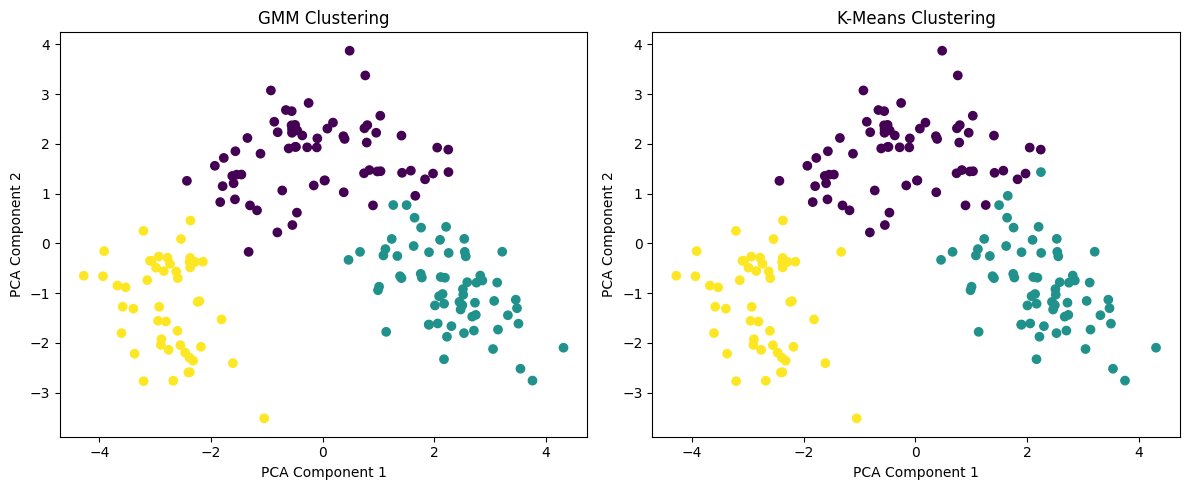

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
            c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
            c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()